In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Read Data

In [2]:
# Tweets Data
df_tweets = pd.read_csv('data/combined_data.csv').iloc[:,1:]
df_tweets['Date'] = df_tweets.Time.apply(pd.to_datetime)
df_tweets = df_tweets.dropna(how='any')
df_tweets.drop(columns='Time', inplace =True)
df_tweets.rename(columns={'Date':'tweet_date'}, inplace = True)
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17327 entries, 0 to 17346
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Content     17327 non-null  object        
 1   tweet_date  17327 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 406.1+ KB


In [3]:
# Get US holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2016-01-01', end='2022-12-31').to_pydatetime()
holiday_date = []
for days in holidays:
    holiday_date.append(days.date())

#check weekend or US holiday
def IsHoliday(x,holiday_date):
    # date = x.date()
    weekday = x.weekday()
    if (x in holiday_date) | (weekday==5) | (weekday==6):
        return True #it is holiday
    else:
        return False #it is not holiday

#during market or after market
def IsAfterMkt(x):
    x = x.time()
    starttime = datetime.strptime('9:30:00','%H:%M:%S').time()
    endtime = datetime.strptime('16:00:00','%H:%M:%S').time()
    if ((x >= starttime) & (x<=endtime)):
         return False
    else:
        return True

# Same day or next day
def IsSameDay(x):
    x = x.time()
    samedaystarttime = datetime.strptime('00:00:00','%H:%M:%S').time()
    samedayndtime = datetime.strptime('9:30:00','%H:%M:%S').time()
    if ((x >= samedaystarttime) & (x < samedayndtime)):
        return True
    else:
        return False


# transform date to correspond to stock market open or close   
def edit_date(x):
    # x = x-timedelta(hours=5)
    date = x.date()
    time = x.time()
    while IsHoliday(date,holiday_date)==1:
        date=date+timedelta(days=1)
    
    if IsAfterMkt(x)==True:
        time=datetime.strptime('9:30:00','%H:%M:%S').time()
        if IsSameDay(x)==False:
            date=date+timedelta(days=1)
    else:
        time=datetime.strptime('16:00:00','%H:%M:%S').time()

    date_time = str(date)+ ' '+ str(time)
    date_time = datetime.strptime(date_time, "%Y-%m-%d %H:%M:%S")
    return date_time

df_tweets['tweet_day'] = df_tweets.tweet_date.apply(lambda row:row.weekday())
df_tweets['Date'] = df_tweets.tweet_date.apply(lambda row:edit_date(row))
df_tweets['Day'] = df_tweets.Date.apply(lambda row:row.weekday())
# df_tweets['Date'].apply(lambda row:row+timedelta(hours=5))

df_tweets.head()

,Content,tweet_date,tweet_day,Date,Day
0,"@haltman Little do they know, birds aren't rea...",2022-03-11 14:41:00,4,2022-03-11 16:00:00,4
1,@waitbutwhy What if one atom at a time in your...,2022-03-10 19:31:00,3,2022-03-11 09:30:00,4
2,@WholeMarsBlog @Erdayastronaut @CopSub This we...,2022-03-10 00:44:00,3,2022-03-10 09:30:00,3
3,@FedorovMykhailo @OMarkarova You're welcome. W...,2022-03-09 16:49:00,2,2022-03-10 09:30:00,3
4,"@PPathole @SpaceX Optimized, fully-reusable St...",2022-03-09 16:41:00,2,2022-03-10 09:30:00,3


In [4]:
# Stocks Data
df_stocks = pd.read_csv('data/tsla_2.csv')
def convert_date(x,h, m):
    x = str.split(x,sep='-')
    x = [int(item) for item in x]
    date = datetime(year=x[0],month=x[1],day=x[2],hour=h, minute=m, second=0)
    return date

df_open = df_stocks[['Date','Open']]
df_open['date'] = df_open.Date.apply(lambda row:convert_date(row, 9, 30))
df_open.drop(columns='Date', inplace=True)
df_open.rename(columns={'Open':'Price','date':'Date'}, inplace = True)

df_close = df_stocks[['Date','Adj Close']]
df_close['date'] = df_close.Date.apply(lambda row:convert_date(row, 16, 00))
df_close.drop(columns='Date', inplace=True)
df_close.rename(columns={'Adj Close':'Price','date':'Date'}, inplace = True)

frames = [df_open, df_close]
df_stocks = pd.concat(frames)
df_stocks = df_stocks.sort_values(by='Date').reset_index(drop=True)
df_stocks['DeltaPCT'] = df_stocks.Price.diff().shift(0)/df_stocks.Price.shift(-1)*100

def stockDirection(x, pct):
     # increase is 2, decrease is 0, remaining constant (+-pct%) is 1
    if x<=-pct/100:
        return 0
    elif x>=pct/100:
        return 2
    else:
        return 1
    

df_stocks['inc/dec'] = df_stocks.DeltaPCT.apply(lambda x: stockDirection(x,0.1))
df_stocks

,Price,Date,DeltaPCT,inc/dec
0,42.972000,2017-01-03 09:30:00,NaN,1
1,43.397999,2017-01-03 16:00:00,0.991848,2
2,42.950001,2017-01-04 09:30:00,-0.986823,0
3,45.397999,2017-01-04 16:00:00,5.405879,2
4,45.284000,2017-01-05 09:30:00,-0.251375,0
...,...,...,...,...
2601,839.289978,2022-03-03 16:00:00,-4.649634,0
2602,849.099976,2022-03-04 09:30:00,1.170239,2
2603,838.289978,2022-03-04 16:00:00,-1.262408,0
2604,856.299988,2022-03-07 09:30:00,2.238436,2


In [5]:
# Date Range
df_date= pd.DataFrame()
df_date['Date'] = pd.bdate_range(start='2017-06-19', end='2022-03-12', freq='min')
df_date

,Date
0,2017-06-19 00:00:00
1,2017-06-19 00:01:00
2,2017-06-19 00:02:00
3,2017-06-19 00:03:00
4,2017-06-19 00:04:00
...,...
2486876,2022-03-11 23:56:00
2486877,2022-03-11 23:57:00
2486878,2022-03-11 23:58:00
2486879,2022-03-11 23:59:00


In [6]:
df = pd.merge(df_date,df_stocks,how='left', on='Date')
df = pd.merge(df, df_tweets, how='left', on='Date')

In [7]:
df = df.dropna().reset_index(drop=True)
#df[(df.Date > '2022-01-01') & (df.Date < '2022-01-05')]

# Tweet Cleaning

In [8]:
# To clean up texts
import re
import nltk
# nltk.download() Download nltk data for first time use (download all packages)
import nltk.data
# from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer('english')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords

# tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('omw-1.4')


In [9]:
stop_words = set(stopwords.words('english'))

def sentence_to_wordlist(sentence, remove_stopwords=False):
    # 0. remove mentions(@), Hashtag(#)
    sentence = re.sub(r'@[^\s]+', '', sentence,flags=re.MULTILINE )
    sentence = re.sub(r'#[^\s]+', '', sentence,flags=re.MULTILINE )
    sentence = re.sub(r'RT[^\s]+', '', sentence,flags=re.MULTILINE )
    # 1. drop http
    p1=re.compile(r'http?:\/\/\S+', flags=re.DOTALL)
    sentence = re.sub(p1, '', sentence)
    # 2. drop https
    p1=re.compile(r'https?:\/\/\S+', flags=re.DOTALL)
    sentence = re.sub(p1, '', sentence)
    # 3. Remove non-letters
    sentence = re.sub(r'[^\w\s]','', sentence)
    # 4. Remove all numbers
    sentence = re.sub(r'[0-9]+', '', sentence)
    # 5. Convert words to lower case and split them
    sentence = sentence.lower().split()
    # Remove Stop Words
    # sentence = [word for word in sentence if not word in stop_words]
    # 5. Stemming
    # sentence = [stemmer.stem(w) for w in sentence] 
    # 6. Lemmatizing
    sentence = [lemmatizer.lemmatize(word) for word in sentence]

    #check if returned sentence is blank
    if len(sentence)==0:
      return np.nan
    else:
      # 7. Return a sentence of words
      sentence_r = ''
      for word in sentence:
        sentence_r = sentence_r + ' ' + word
      return(sentence_r)

# def cleanText(text):
#   text = re.sub('@[A-Za-z0-9]+' , '', text) #remove the @mentions
#   text = re.sub('https?:\/\/\S+' , '', text) #remove the hyperlinks
#   text = re.sub(r'#', '', text) #removing #tags
#   text = re.sub(r'RT[\s]+', '', text) #removing RT(ReTweets)
#   return text

In [10]:
# create a new column 
df['Content1']= df.Content.apply(lambda row: sentence_to_wordlist(row))
df.dropna(how='any', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15003 entries, 0 to 16097
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        15003 non-null  datetime64[ns]
 1   Price       15003 non-null  float64       
 2   DeltaPCT    15003 non-null  float64       
 3   inc/dec     15003 non-null  float64       
 4   Content     15003 non-null  object        
 5   tweet_date  15003 non-null  datetime64[ns]
 6   tweet_day   15003 non-null  float64       
 7   Day         15003 non-null  float64       
 8   Content1    15003 non-null  object        
dtypes: datetime64[ns](2), float64(5), object(2)
memory usage: 1.1+ MB


# Tweet Sentiments

In [11]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon', quiet=True)

def polarityScore(a, col):
    # Create a column for score
    a['score'] = a[col].apply(lambda row: calculate_polarity_scores(row))
    #split all the scores into separate columns
    # columns = ['negative', 'neutral', 'positive', 'compound'])
    a['negative']=a.score.apply(lambda x: x[0])
    a['neutral']=a.score.apply(lambda x: x[1])
    a['positive']=a.score.apply(lambda x: x[2])
    a['combined']=a.score.apply(lambda x: x[3])
    return a

def calculate_polarity_scores(x):
    sid = SentimentIntensityAnalyzer()
    score = sid.polarity_scores(x)
    score_list = []
    for i in score.values():
        score_list.append(i)
    return score_list

In [12]:
result = polarityScore(df, 'Content1')
# sns.histplot(data=result, x='compound')
result.head()

,Date,Price,DeltaPCT,inc/dec,Content,tweet_date,tweet_day,Day,Content1,score,negative,neutral,positive,combined
0,2017-06-19 09:30:00,75.000000,0.973501,2.0,Elon Musk posted a video on Twitter from the p...,2017-06-19 04:32:00,0.0,0.0,elon musk posted a video on twitter from the ...,"[0.0, 1.0, 0.0, 0.0]",0.00,1.000,0.000,0.0000
1,2017-12-04 16:00:00,61.040001,-0.430461,0.0,That special hat delivery will take place deep...,2017-12-03 15:01:00,6.0,0.0,that special hat delivery will take place dee...,"[0.0, 0.944, 0.056, 0.2144]",0.00,0.944,0.056,0.2144
2,2017-12-04 16:00:00,61.040001,-0.430461,0.0,@NefuDaBoss Beyond anything you can imagine,2017-12-03 14:37:00,6.0,0.0,beyond anything you can imagine,"[0.0, 1.0, 0.0, 0.0]",0.00,1.000,0.000,0.0000
3,2017-12-04 16:00:00,61.040001,-0.430461,0.0,"@TheRealUtkarsh And, at the risk of stating th...",2017-12-03 14:33:00,6.0,0.0,and at the risk of stating the obvious extrem...,"[0.37, 0.63, 0.0, -0.5709]",0.37,0.630,0.000,-0.5709
4,2017-12-04 16:00:00,61.040001,-0.430461,0.0,@TheRealUtkarsh Because it's stupid,2017-12-03 14:29:00,6.0,0.0,because it stupid,"[0.63, 0.37, 0.0, -0.5267]",0.63,0.370,0.000,-0.5267


<AxesSubplot:xlabel='combined', ylabel='Count'>

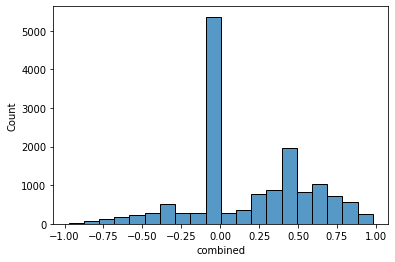

In [13]:
import seaborn as sns
sns.histplot(data=result, x='combined',bins=20)

<AxesSubplot:xlabel='inc/dec', ylabel='Count'>

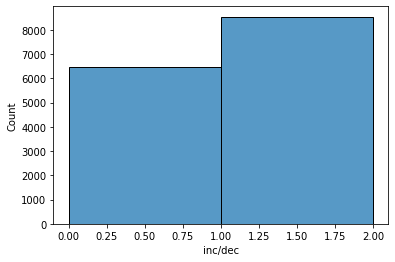

In [14]:
sns.histplot(data=result, x='inc/dec',bins=2)

# Last Step 

In [15]:
result.groupby(['Date'])[['combined','negative','neutral','positive','inc/dec']]\
    .mean().reset_index(drop=True)\
    .to_csv('data/finaldata.csv',index=False, header=True)

In [16]:
result.groupby(['Date'])[['combined','negative','neutral','positive','inc/dec']].mean().reset_index(drop=True)

,combined,negative,neutral,positive,inc/dec
0,0.000000,0.000000,1.000000,0.00000,2.0
1,-0.031450,0.121500,0.841500,0.03700,0.0
2,0.231475,0.000000,0.901250,0.09875,0.0
3,0.000000,0.000000,1.000000,0.00000,0.0
4,0.201050,0.000000,0.672250,0.32775,2.0
...,...,...,...,...,...
1732,0.268850,0.068667,0.645667,0.28550,0.0
1733,-0.011789,0.059111,0.836889,0.10400,0.0
1734,0.167250,0.055500,0.835750,0.10875,2.0
1735,-0.299700,0.140500,0.859500,0.00000,0.0


In [20]:
result[['Date','Content','Content1','combined','negative','neutral','positive','inc/dec']].to_csv('data/results.csv',index=False, sep=',')